In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import folium
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

from PIL import Image
from typing import Callable
from datetime import datetime
from helper_functions import *
from skimage.morphology import *

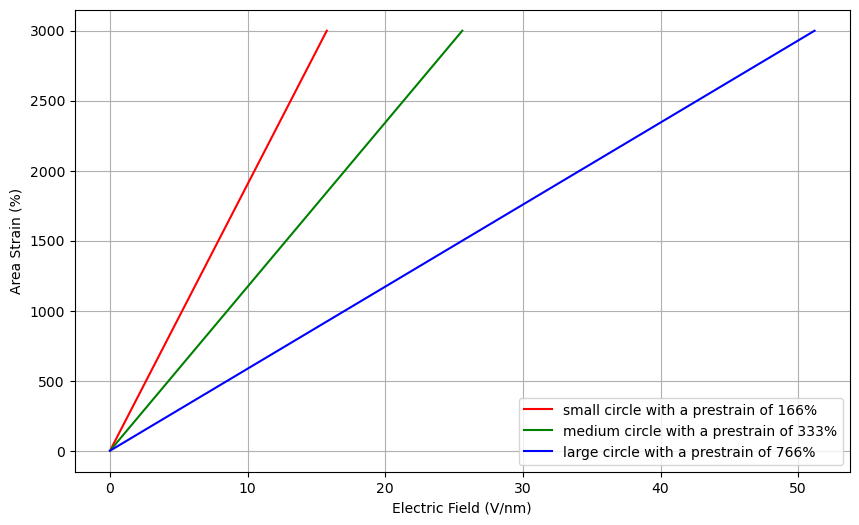

In [9]:
# aucun rapport 

x1 = np.array([0,0.008460962,0.056013709,0.113848131,0.141694334,0.192353004,0.222234122])
x2 = np.array([0,0.025893844,0.094729082,0.149557685,0.205399926,0.271286399,0.328971618])
x3 = np.array([0,0.040719697,0.104482323,0.198232323,0.386837121,0.68844697,1.076388889])
y = np.array([0, 500, 1000, 1500, 2000, 2500, 3000])

prestrains = np.array([(8-3)/3,(13-3)/3,(26-3)/3])

t0 = 508  # original thickness in um

colors = ['r','g','b']
circles =["small","medium","large"]
# Calculate new thicknesses
thicknesses = t0 / (1 + prestrains)

electric_fields = [y / t for t in thicknesses]

# Plotting
plt.figure(figsize=(10, 6))
for i, ef in enumerate(electric_fields):
    plt.plot(ef, y, label=circles[i] + f' circle with a prestrain of {int(prestrains[i]*100)}%', color=colors[i])  # assuming area strain proportional to voltage

plt.xlabel('Electric Field (V/nm)')
plt.ylabel('Area Strain (%)')
# plt.title('DEA Circle Actuators: Area Strain vs Electric field')
plt.grid()
plt.legend()
plt.show()

# plt.figure(figsize=(8, 8))
# plt.plot(x1, y, label='small circle', color='r')
# plt.plot(x2, y, label='medium circle', color='g')
# plt.plot(x3, y, label='large circle',  color='b')
# plt.xlabel('Area Strain')
# plt.ylabel('Voltage')
# plt.title('DEA Circle Actuators: Voltage vs Area Strain')
# plt.legend()
# plt.grid()
# plt.show()

# # save this plot in .png
# plt.savefig('DEA_Circle_Actuators.png')



In [10]:
# !pip install scikit-image

## **Data & Images**

(-0.5, 5999.5, 3999.5, -0.5)

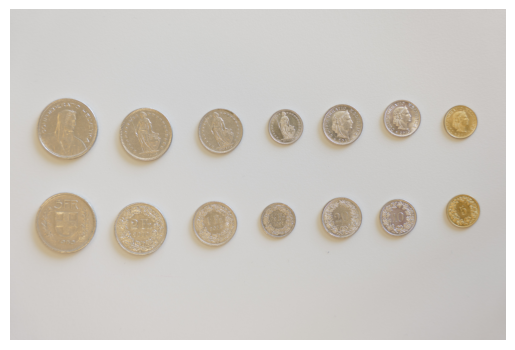

In [2]:
# Define path
path = './ref/ref_chf.JPG'

# path_he = os.path.join("..", "ref", "ref_euro.JPG")
# Check if folder and image exist
# assert os.path.exists(path), "Image not found, please check directory structure"

# Load image
img_he = np.array(Image.open(path))

# Display image
plt.imshow(img_he)
plt.axis('off')

In [4]:
# load data
sample_submission = pd.read_csv("sample_submission.csv")
train_labels = pd.read_csv("train_labels.csv")

In [5]:
# display data 
display(sample_submission.head())

display(train_labels.head())

id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
0  L0000000     0     0     0       0       0       0        0     0     0   
1  L0000001     0     0     0       0       0       0        0     0     0   
2  L0000002     0     0     0       0       0       0        0     0     0   
3  L0000003     0     0     0       0       0       0        0     0     0   
4  L0000004     0     0     0       0       0       0        0     0     0   

   0.5EUR  0.2EUR  0.1EUR  0.05EUR  0.02EUR  0.01EUR  OOD  
0       0       0       0        0        0        0    0  
1       0       0       0        0        0        0    0  
2       0       0       0        0        0        0    0  
3       0       0       0        0        0        0    0  
4       0       0       0        0        0        0    0

id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
0  L1010281     0     0     0       0       2       3        1     0     0   
1  L1010298     0     2     1       2       0       0        0     0     0   
2  L1010321     0     0     1       2       0       0        0     1     2   
3  L1010310     0     0     1       1       0       0        1     2     0   
4  L1010300     0     1     0       0       0       0        0     1     0   

   0.5EUR  0.2EUR  0.1EUR  0.05EUR  0.02EUR  0.01EUR  OOD  
0       0       0       0        2        0        0    0  
1       0       0       0        0        0        0    0  
2       0       2       1        0        0        0    0  
3       1       0       0        0        1        0    0  
4       2       0       1        0        0        0    0

In [6]:
# verify if there is any missing values
print("Train labels missing values: ", train_labels.columns[train_labels.isna().any()].tolist())

Train labels missing values:  []


In [7]:
# compute the number of coins for each id of the dataset "train_label"
column_sums = train_labels.sum()
column_sums

id         L1010281L1010298L1010321L1010310L1010300L10103...
5CHF                                                      27
2CHF                                                      22
1CHF                                                      21
0.5CHF                                                    19
0.2CHF                                                    11
0.1CHF                                                    18
0.05CHF                                                   16
2EUR                                                      32
1EUR                                                      10
0.5EUR                                                    33
0.2EUR                                                    29
0.1EUR                                                    25
0.05EUR                                                   30
0.02EUR                                                   23
0.01EUR                                                   17
OOD                     

In [9]:
train_labels.describe()

5CHF       2CHF       1CHF     0.5CHF     0.2CHF     0.1CHF  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean    0.333333   0.271605   0.259259   0.234568   0.135802   0.222222   
std     0.547723   0.524699   0.542627   0.481446   0.379246   0.547723   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     1.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
max     2.000000   2.000000   3.000000   2.000000   2.000000   3.000000   

         0.05CHF       2EUR       1EUR     0.5EUR     0.2EUR     0.1EUR  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean    0.197531   0.395062   0.123457   0.407407   0.358025   0.308642   
std     0.510386   0.584787   0.366835   0.607819   0.638526   0.515800   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   1.000000   0.000000   1.000000   1.000000   1.000000   
max     3.000000   2.000000   2.000000   2.000000   2.000000   2.000000   

        0.05EUR    0.02EUR    0.01EUR        OOD  
count  81.00000  81.000000  81.000000  81.000000  
mean    0.37037   0.283951   0.209877   0.604938  
std     0.71492   0.553050   0.466799   0.683356  
min     0.00000   0.000000   0.000000   0.000000  
25%     0.00000   0.000000   0.000000   0.000000  
50%     0.00000   0.000000   0.000000   0.000000  
75%     1.00000   0.000000   0.000000   1.000000  
max     3.00000   2.000000   2.000000   2.000000

## **Image analysis**

### **Segmentation**

1. Detecter les coins depuis le fichier "ref" (etant donne que c'est des "neutral_bg" et tout les monnaies y sont affiches pile/face)
2. Detecter sur les noisy_bg et hand

#### **RGB**

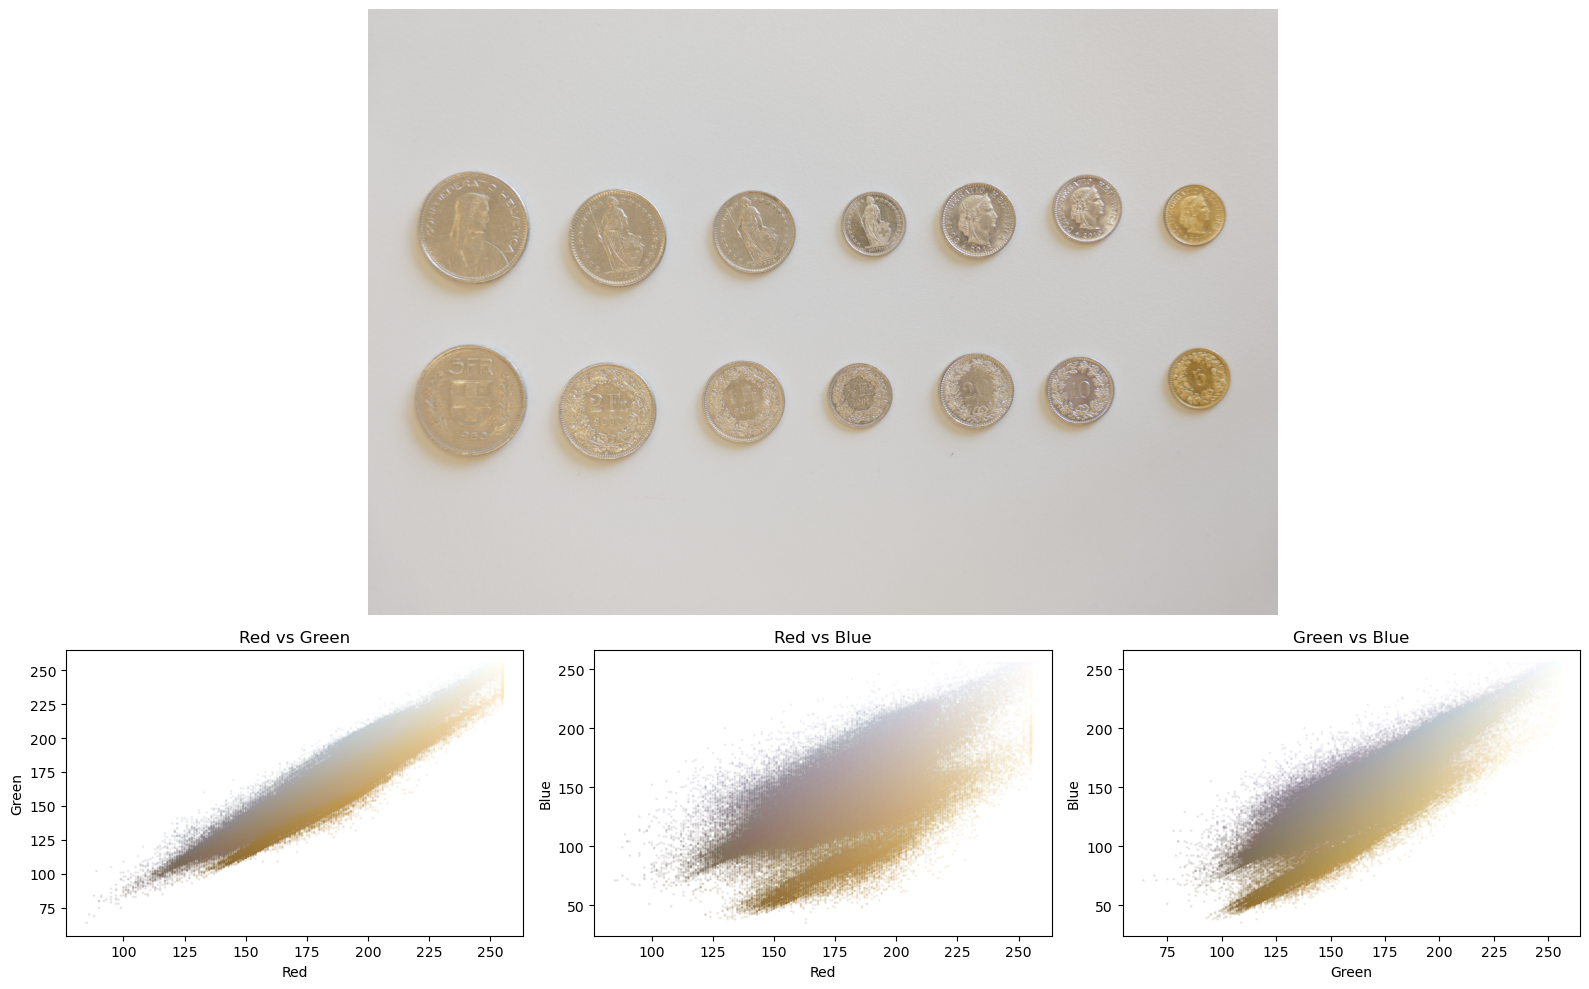

In [8]:
# Call plotting function with your implemented function
plot_colors_histo(
    img = img_he,
    func = extract_rgb_channels,
    labels = ["Red", "Green", "Blue"],
)

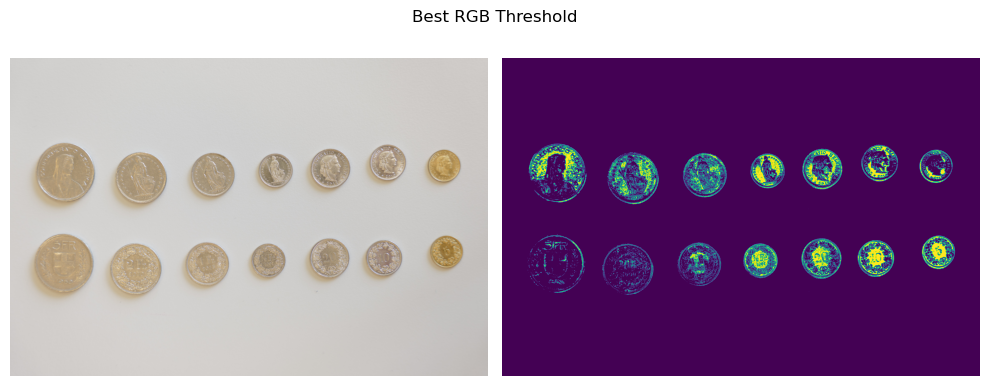

In [13]:
# Plot best RGB thresholding
# values = [150,125,100] un tout petit peu
# values = [150,110,60] nulle
# values = [150,125,70] nulle
# values = [150,125,50] nulle
# values = [175,150,125] pas mal
values = [175,150,150] # best
# values = [175,150,100] 

plot_thresholded_image(img=img_he, func=apply_rgb_threshold, title="Best RGB Threshold", rgb=values)

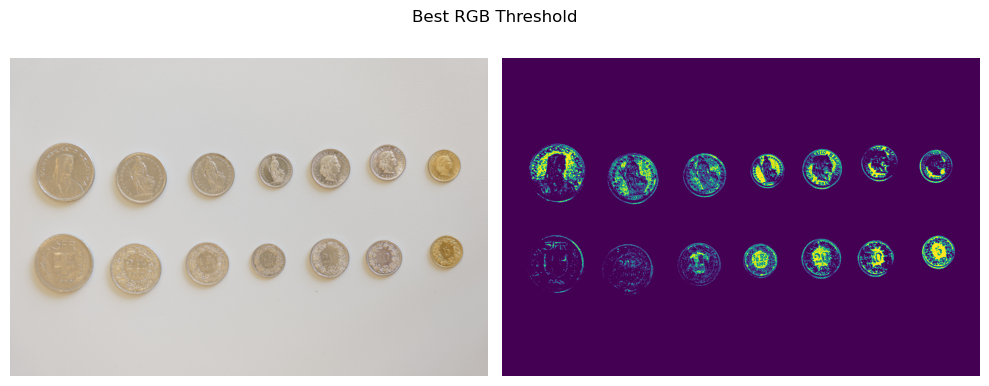

In [7]:
# Plot best RGB thresholding
# values = [150,125,100] un tout petit peu
# values = [150,110,60] nulle
# values = [150,125,70] nulle
# values = [150,125,50] nulle
values = [175,150,125]

plot_thresholded_image(img=img_he, func=apply_rgb_threshold, title="Best RGB Threshold", rgb=values)

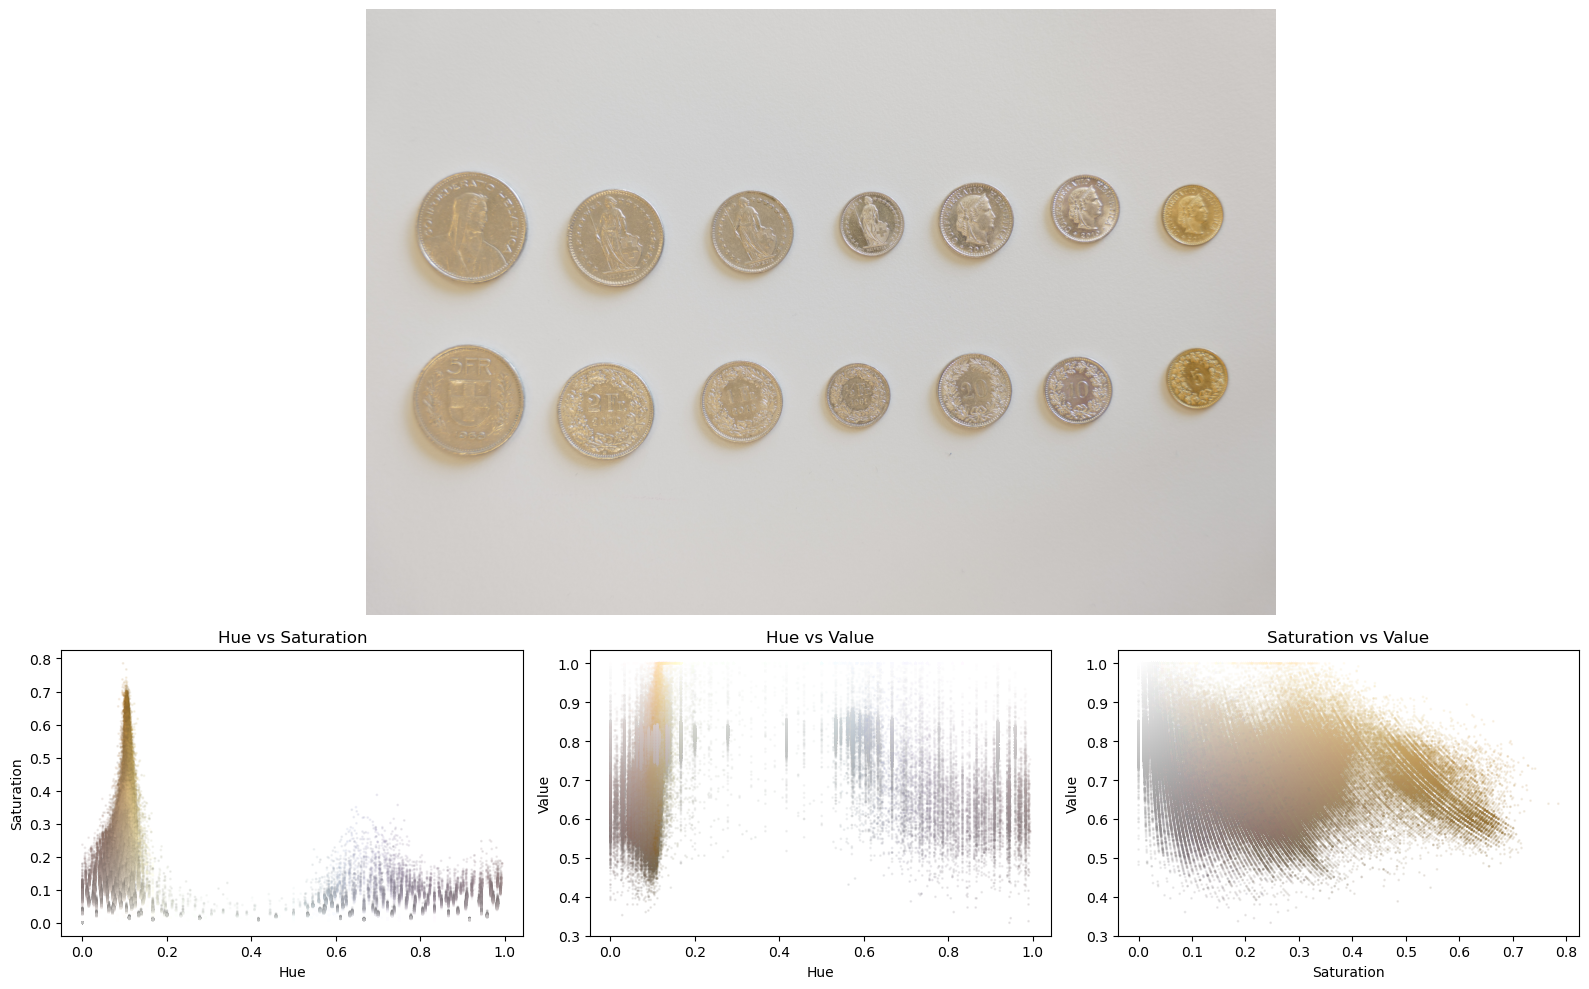

In [3]:
# Call plotting function with your implemented function
plot_colors_histo(
    img = img_he,
    func = extract_hsv_channels,
    labels = ["Hue", "Saturation", "Value"],
)

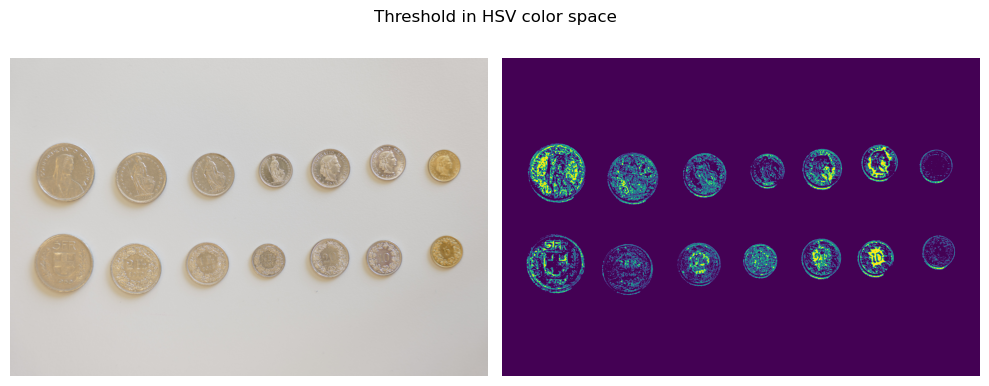

In [7]:
values = [0.1,0.2,0.7] # pas mal 
# values = [0.1,0.25,0.7]

# Find threshold(s) in the hsv channels
plot_thresholded_image(img=img_he, func=apply_hsv_threshold, title="Threshold in HSV color space", rgb = values)

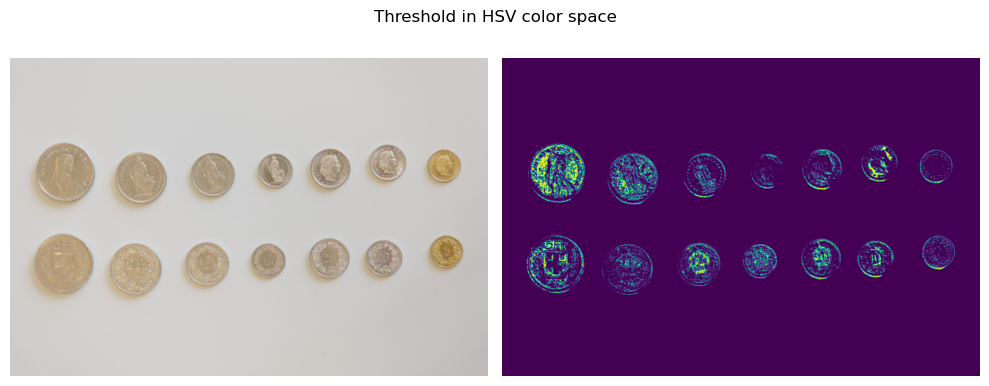

In [6]:
# values = [0.1,0.2,0.7] # pas mal 
values = [0.1,0.25,0.7]

# Find threshold(s) in the hsv channels
plot_thresholded_image(img=img_he, func=apply_hsv_threshold, title="Threshold in HSV color space", rgb = values)

#### **Morphology**

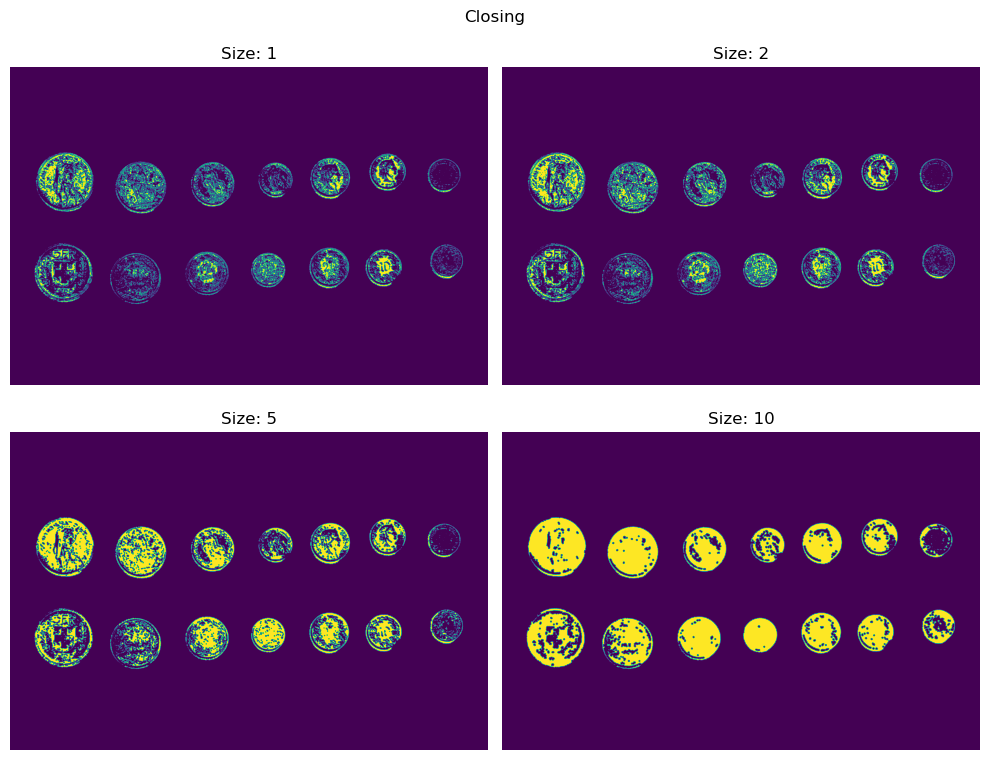

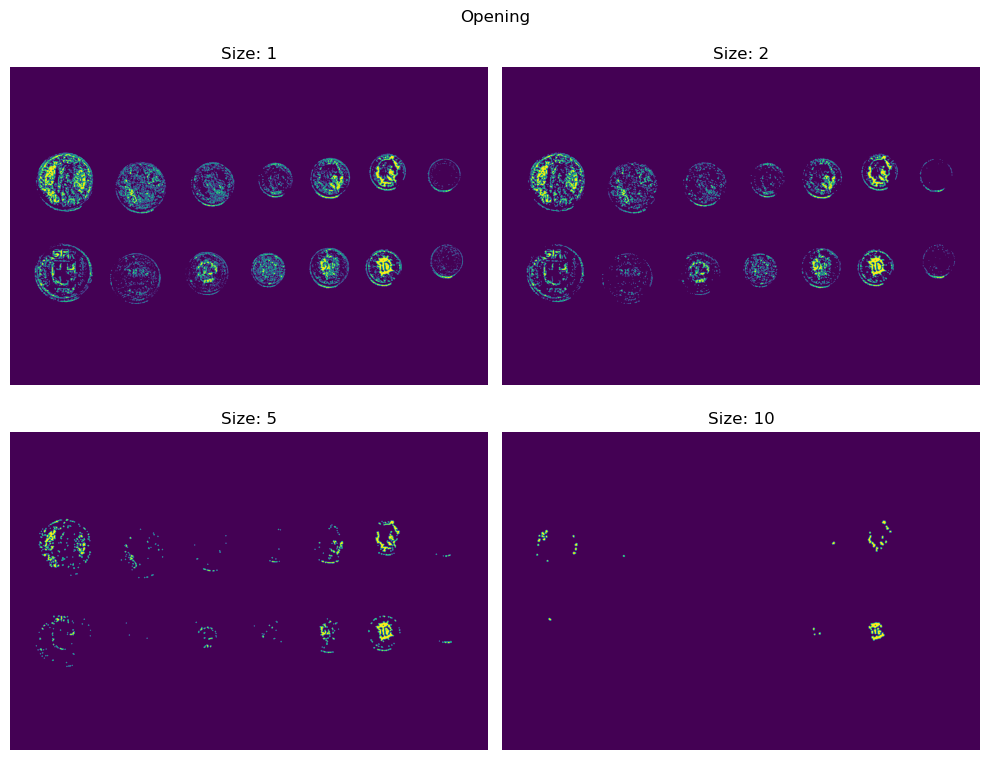

In [8]:
values_hsv = [0.1,0.2,0.7]
# Define disk sizes
disk_sizes = [1, 2, 5, 10]
imgs_closing = []
imgs_opening = []
# Apply threhsold in HSV space
img_th = apply_hsv_threshold(img_he,values_hsv)

# Apply opening and closing to masked image 
for d in disk_sizes:
    imgs_closing.append(apply_closing(img_th, d))
    imgs_opening.append(apply_opening(img_th, d))
    
# Plot results
plot_images(imgs=imgs_closing, sizes=disk_sizes, title="Closing")
plot_images(imgs=imgs_opening, sizes=disk_sizes, title="Opening")

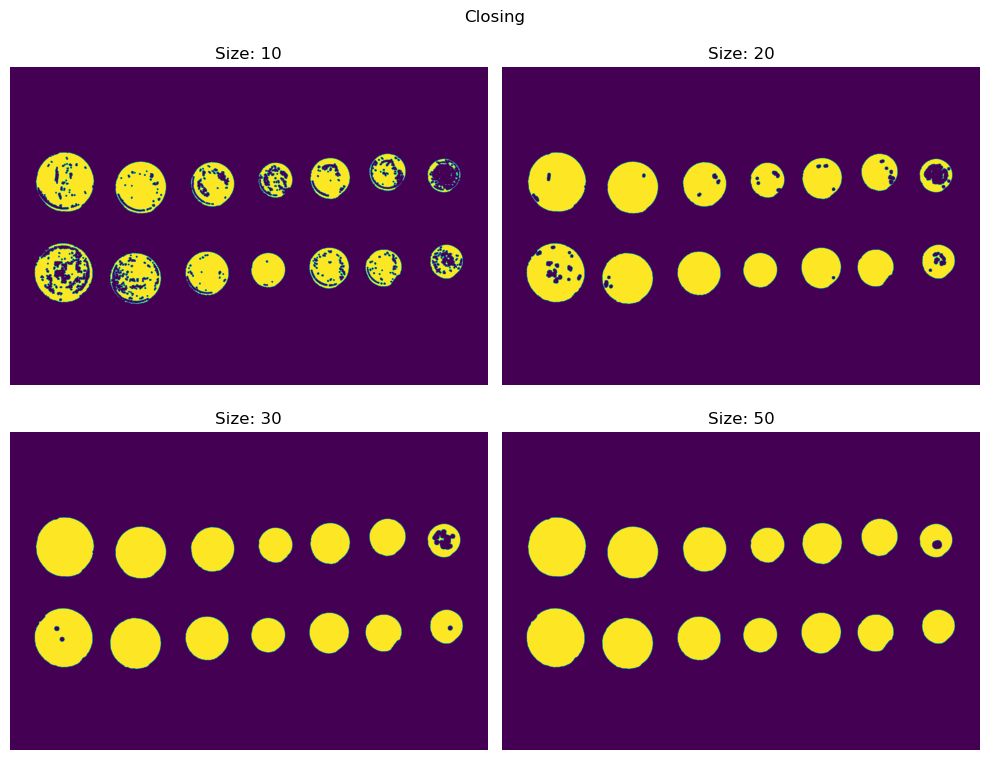

In [10]:
values_hsv = [0.1,0.2,0.7]
# Define disk sizes
disk_sizes = [10, 20, 30, 50]
imgs_closing = []
# Apply threhsold in HSV space
img_th = apply_hsv_threshold(img_he,values_hsv)

# Apply opening and closing to masked image 
for d in disk_sizes:
    imgs_closing.append(apply_closing(img_th, d))
    
# Plot results
plot_images(imgs=imgs_closing, sizes=disk_sizes, title="Closing")

In [ ]:
values_hsv = [0.1,0.2,0.7]
# Define disk sizes
disk_sizes = [50]
imgs_closing = []
# Apply threhsold in HSV space
img_th = apply_hsv_threshold(img_he,values_hsv)

# Apply opening and closing to masked image 
for d in disk_sizes:
    imgs_closing.append(apply_closing(img_th, d))
    
# Plot results
plot_images(imgs=imgs_closing, sizes=disk_sizes, title="Closing")

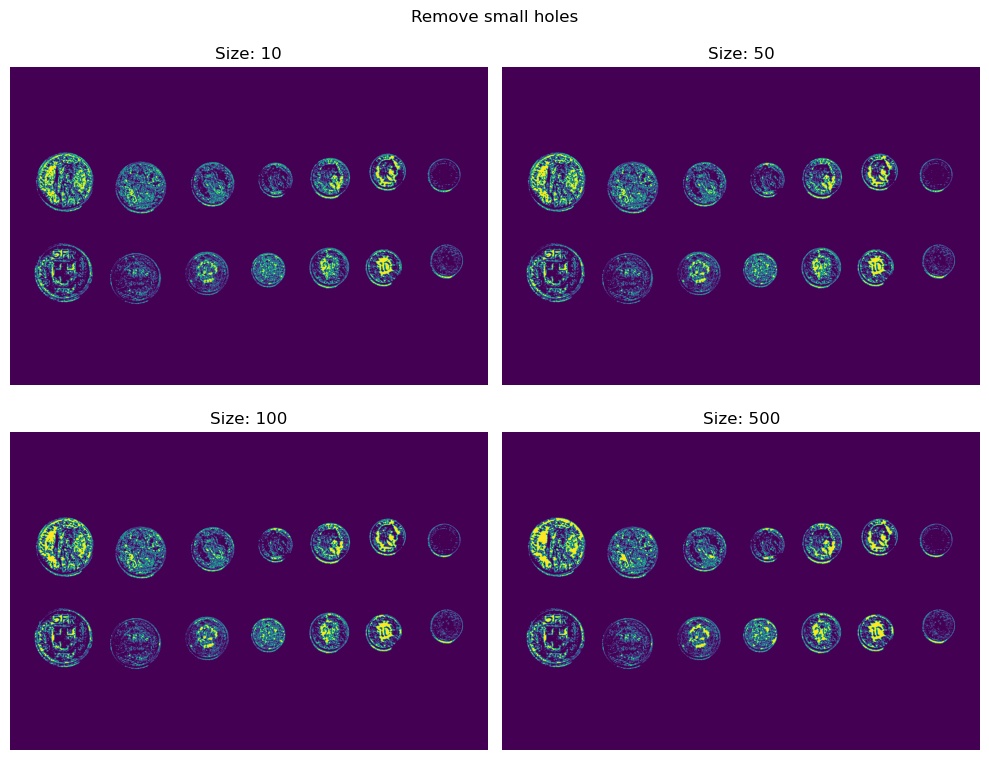

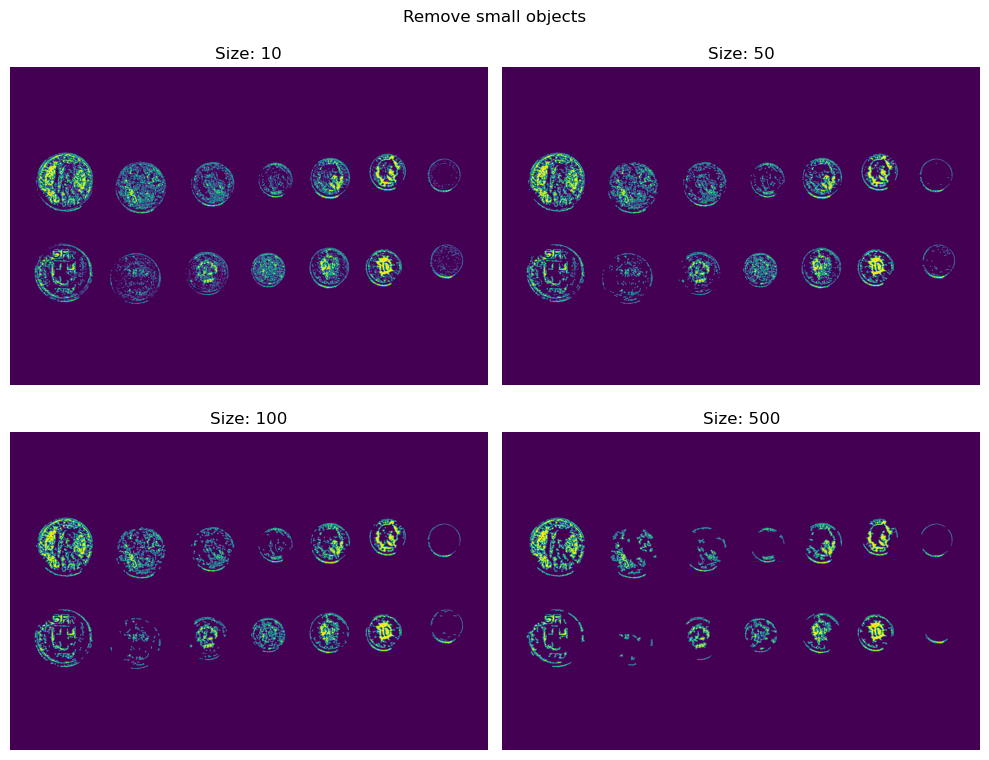

In [3]:
values_hsv = [0.1,0.2,0.7]

# Define area sizes
sizes = [10, 50, 100, 500]
imgs_holes = []
imgs_objects = []
# Apply threhsold in HSV space
img_th = apply_hsv_threshold(img_he, values_hsv)

# Remove holes and objects from masked image 
for d in sizes:
    imgs_holes.append(remove_holes(img_th, d))
    imgs_objects.append(remove_objects(img_th, d))
    
# Plot results    
plot_images(imgs=imgs_holes, sizes=sizes, title="Remove small holes")
plot_images(imgs=imgs_objects, sizes=sizes, title="Remove small objects")

#### **Region Growing**
on pourrait creer une fonction ou, on detecte quiil y a un objet, on enregistre les points et apres on fait un region growing sur ca 

### **Description**

1. Detecter les formes de cercle des monnaies 
2. Calculer leur taille (etant donne que les photos sont prises a la meme hauteur)

### **Classification**
1. Classifier les monnaies chf/euro et valeurs selon leurs tailles

Questions:
- comment differencier si c'est pile/face
- comment differencier les couleurs
- c quoi les odd